In [1]:
using Images
using PyPlot

# Create 3x3 derivative filters in x and y direction
function createfilters()
    gaussian_filter = [1/sqrt(2*pi)/0.9*exp(1/2/0.9^2) 1/sqrt(2*pi)/0.9 1/sqrt(2*pi)/0.9*exp(1/2/0.9^2)]
    derivative_filter = [1/2 0 -1/2]
    fx = transpose(gaussian_filter) * derivative_filter
    fx = fx / sum(abs.(fx))
    fy = transpose(derivative_filter) * gaussian_filter
    fy = fy / sum(abs.(fy))
  return fx::Array{Float64,2}, fy::Array{Float64,2}
end

# Apply derivate filters to an image and return the derivative images
function filterimage(I::Array{Float32,2},fx::Array{Float64,2},fy::Array{Float64,2})
    Ix = imfilter(I, fx, "replicate")
    Iy = imfilter(I, fy, "replicate")

  return Ix::Array{Float64,2},Iy::Array{Float64,2}
end

# Apply thresholding on the gradient magnitudes to detect edges
function detectedges(Ix::Array{Float64,2},Iy::Array{Float64,2}, thr::Float64)
    edges = sqrt.(Ix.^2 + Iy.^2)
    for i = 1: length(edges)
        if edges[i] < thr
            edges[i] = 0
        end
    end
  return edges::Array{Float64,2}
end

# Apply non-maximum-suppression
function nonmaxsupp(edges::Array{Float64,2},Ix::Array{Float64,2},Iy::Array{Float64,2})
    
    theta = atan.(Iy, Ix)
    for i = 2:size(edges, 1)-1
        for j = 2:size(edges, 2)-1
            
            if theta[i, j] >= 0 && theta[i, j] < pi/4
                temp = 1*tan(theta[i, j])
                interpolated_magnitude_1 = edges[i, j+1]*(1-temp) + edges[i-1, j+1] * temp
                interpolated_magnitude_2 = edges[i, j-1]*(1-temp) + edges[i+1, j-1] * temp
                if !(edges[i, j] > interpolated_magnitude_1 && edges[i, j] > interpolated_magnitude_2)
                    edges[i,j] = 0
                end
                
            elseif theta[i, j] >= pi/4 && theta[i, j] < pi/2
                temp = 1/tan(theta[i, j])
                interpolated_magnitude_1 = edges[i-1, j]*(1-temp) + edges[i-1, j+1] * temp
                interpolated_magnitude_2 = edges[i+1, j]*(1-temp) + edges[i+1, j-1] * temp
                if !(edges[i, j] > interpolated_magnitude_1 && edges[i, j] > interpolated_magnitude_2)
                    edges[i,j] = 0
                end
                
            elseif theta[i, j] >= pi/2 && theta[i, j] < 3*pi/4
                temp = abs(1/tan(theta[i, j]))
                interpolated_magnitude_1 = edges[i-1, j]*(1-temp) + edges[i-1, j-1] * temp
                interpolated_magnitude_2 = edges[i+1, j]*(1-temp) + edges[i+1, j+1] * temp
                if !(edges[i, j] > interpolated_magnitude_1 && edges[i, j] > interpolated_magnitude_2)
                    edges[i,j] = 0
                end
                
            elseif theta[i, j] >= 3*pi/4 && theta[i, j] < pi
                temp = abs(1 * tan(theta[i, j]))
                interpolated_magnitude_1 = edges[i, j-1]*(1-temp) + edges[i-1, j-1] * temp
                interpolated_magnitude_2 = edges[i, j+1]*(1-temp) + edges[i+1, j+1] * temp
                if !(edges[i, j] > interpolated_magnitude_1 && edges[i, j] > interpolated_magnitude_2)
                    edges[i,j] = 0
                end
                
            elseif theta[i, j] >= pi && theta[i, j] < 5*pi/4
                temp = 1 * tan(theta[i, j])
                interpolated_magnitude_1 = edges[i, j-1]*(1-temp) + edges[i+1, j-1] * temp
                interpolated_magnitude_2 = edges[i, j+1]*(1-temp) + edges[i-1, j+1] * temp
                if !(edges[i, j] > interpolated_magnitude_1 && edges[i, j] > interpolated_magnitude_2)
                    edges[i,j] = 0
                end
                
            elseif theta[i, j] >= 5*pi/4 && theta[i, j] < 3*pi/2
                temp = 1 / tan(theta[i, j])
                interpolated_magnitude_1 = edges[i+1, j]*(1-temp) + edges[i+1, j-1] * temp
                interpolated_magnitude_2 = edges[i-1, j]*(1-temp) + edges[i-1, j+1] * temp
                if !(edges[i, j] > interpolated_magnitude_1 && edges[i, j] > interpolated_magnitude_2)
                    edges[i,j] = 0
                end
                
            elseif theta[i, j] >= 3*pi/2 && theta[i, j] < 7*pi/4
                temp = abs(1 / tan(theta[i, j]))
                interpolated_magnitude_1 = edges[i+1, j]*(1-temp) + edges[i+1, j+1] * temp
                interpolated_magnitude_2 = edges[i-1, j]*(1-temp) + edges[i-1, j-1] * temp
                if !(edges[i, j] > interpolated_magnitude_1 && edges[i, j] > interpolated_magnitude_2)
                    edges[i,j] = 0
                end
            
            else 
                temp = abs(1 * tan(theta[i, j]))
                interpolated_magnitude_1 = edges[i, j+1]*(1-temp) + edges[i+1, j+1] * temp
                interpolated_magnitude_2 = edges[i, j-1]*(1-temp) + edges[i-1, j-1] * temp
                if !(edges[i, j] > interpolated_magnitude_1 && edges[i, j] > interpolated_magnitude_2)
                    edges[i,j] = 0
                end
            end
        end
    end
    
  return edges::Array{Float64,2}
end

#= Problem 4
Image Filtering and Edge Detection =#

function problem4()

  # load image
  img = PyPlot.imread("a1p4.png")

  # create filters
  fx, fy = createfilters()

  # filter image
  imgx, imgy = filterimage(img, fx, fy)

  # show filter results
  figure()
  subplot(121)
  imshow(imgx, "gray", interpolation="none")
  title("x derivative")
  axis("off")
  subplot(122)
  imshow(imgy, "gray", interpolation="none")
  title("y derivative")
  axis("off")
  gcf()

  # show gradient magnitude
  figure()
  imshow(sqrt.(imgx.^2 + imgy.^2),"gray", interpolation="none")
  axis("off")
  title("Derivative magnitude")
  gcf()

  # threshold derivative
#####
    # Here we may choose from [10, 20, 38, 50]
  threshold = 38. / 255.  
#####
    
  edges = detectedges(imgx,imgy,threshold)
  figure()
  imshow(edges.>0, "gray", interpolation="none")
  axis("off")
  title("Binary edges")
  gcf()

  # non maximum suppression
  edges2 = nonmaxsupp(edges,imgx,imgy)
  figure()
  imshow(edges2,"gray", interpolation="none")
  axis("off")
  title("Non-maximum suppression")
  gcf()
  return
end

problem4 (generic function with 1 method)

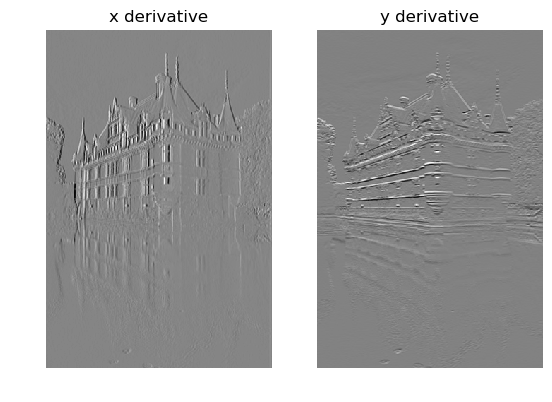

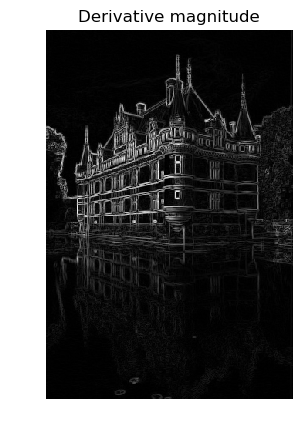

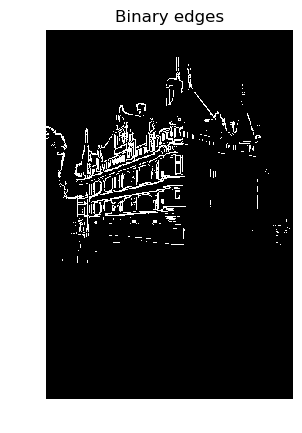

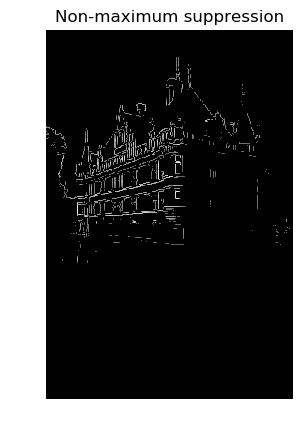

┌ Warning: assuming that the origin is at the center of the kernel; to avoid this warning, call `centered(kernel)` or use an OffsetArray
│   caller = kernelshift at imfilter.jl:1509 [inlined]
└ @ Core /Users/hejin9202/.julia/packages/ImageFiltering/bMda8/src/imfilter.jl:1509
┌ Warning: assuming that the origin is at the center of the kernel; to avoid this warning, call `centered(kernel)` or use an OffsetArray
│   caller = kernelshift at imfilter.jl:1509 [inlined]
└ @ Core /Users/hejin9202/.julia/packages/ImageFiltering/bMda8/src/imfilter.jl:1509


In [2]:
problem4()

#=
I tried out different threshold values from the list [10, 20, 38, 50]
With the plots shown for each candidate, we can tell 20 might be proper value
so that more details can be captured.

=#

In [3]:
cent_diff_x = [-.5, 0, .5]
  cent_diff_y = cent_diff_x'

  # just need to calculate for x=1, since x=-1 is treated the same due to x^2
  sigma = .9
  gauss_1, gauss_0 = (1/(sqrt(2*pi)*sigma)) * [exp(-1/(2*(sigma^2))), exp(0)]

  x_gauss = [gauss_1, gauss_0, gauss_1]
  y_gauss = x_gauss'

  fx = cent_diff_x * y_gauss
  fy = x_gauss * cent_diff_y

3×3 Array{Float64,2}:
 -0.119551  0.0  0.119551
 -0.221635  0.0  0.221635
 -0.119551  0.0  0.119551